In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/yolo_dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/yolo_dataset/train/labels/levle1_604_png_jpg.rf.58cfefd6b60320346ff439896be7eadc.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_604_png_jpg.rf.add8f585583e6e9e1b198850cd662647.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_604_png_jpg.rf.b37c92b026a3b6f275913dafe6ac1069.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_605_jpg.rf.18fa1cdbd9786b5159b015cf4850bb37.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_605_jpg.rf.5db0348ae538f404ecd73612281f8308.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_605_jpg.rf.a814eabb1086d086e07f5e2ef96c480e.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_606_jpg.rf.04b58e2e63353cc51c4b452fa64f2f97.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_606_jpg.rf.0510c7c88fcec00f2e87ac1585cdea4c.txt  
  inflating: /content/yolo_dataset/train/labels/levle1_606_jpg.rf.8621e0cda9940a61069e509d9ed360f

In [ ]:
!ls -l /content/

In [5]:
!pip install pycocotools

In [4]:
import torch
torch.__version__

'2.4.1+cu121'

# Training Mask R-CNN Model

In [3]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from custom_dataset_loader import CustomCocoManualDataset
import time
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training (optional)

In [4]:
#Initializing Datasets
train_dataset = CustomCocoManualDataset(
    root='yolo_dataset/train/images',  # Path to images
    annFile='yolo_dataset/train/annotations/coco_annotation.json',  # Path to COCO annotations
    transforms=T.ToTensor()  # Apply ToTensor transform
)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [5]:
valid_dataset = CustomCocoManualDataset(
    root='yolo_dataset/valid/images',  #Path to images
    annFile='yolo_dataset/valid/annotations/coco_annotation.json',  #Path to COCO annotations
    transforms=T.ToTensor()  # Apply ToTensor transform ->
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size=34,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    collate_fn= lambda batch: tuple(zip(*batch))
)

In [7]:
validation_loader = DataLoader(
    valid_dataset,
    batch_size=34,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    collate_fn= lambda batch: tuple(zip(*batch))
)

In [8]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 216MB/s]


In [9]:
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [10]:
#box predictor
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256


In [11]:
# Passing the model to the device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is,",device)
model.to(device)

Device is, cuda


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
#configuring Adam optimizer for the model

lr = 0.001
weight_decay = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = GradScaler()

<ipython-input-12-f0db6abc2abb>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [15]:
num_epochs = 40
train_losses = []
valid_losses = []
iou_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
map_scores = []


In [14]:
num_epochs = 10

# Initialize variables to store training and validation metrics
train_losses = {
    "classification-loss": [],
    "regression-loss": [],
    "mask-loss": [],
    "rpn-classification-loss": [],
    "rpn-regression-loss": [],
    "total-loss": [],
    "total-avg": []
}

In [16]:
def calc_loss(loss_dict):
    classification_loss = loss_dict['loss_classifier']
    regression_loss = loss_dict['loss_box_reg']
    mask_loss = loss_dict['loss_mask']
    rpn_class_loss = loss_dict['loss_objectness']
    rpn_reg_loss = loss_dict['loss_rpn_box_reg']
    total_loss = sum(loss for loss in loss_dict.values())

    return classification_loss, regression_loss, mask_loss, rpn_class_loss, rpn_reg_loss,total_loss

In [18]:
torch.backends.cudnn.benchmark = True  # Use benchmark mode to speed up training

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    # Training loop
    for i, (images, targets) in enumerate(train_loader):

        # Loading images and forward pass
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward propagation
        with autocast():
            # Loss calculation
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backward propagation
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

        # Log progress after every 10 batches
        if (i + 1) % 10 == 0:
            print(f'Epoch: [{epoch+1}/{num_epochs}], Batch: [{i}/{len(train_loader)}], Loss: {losses.item():4f}')

    # Average training loss for the epoch
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch: [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f} s')

    # Validation step
    model.train()  # Keep the model in train mode to compute the validation loss properly
    validation_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations
        for i, (images, targets) in enumerate(validation_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast():
                # Calculate validation loss during evaluation in training mode
                val_loss_dict = model(images, targets)
                val_losses = sum(loss for loss in val_loss_dict.values())

            validation_loss += val_losses.item()

    # Average validation loss for the epoch
    validation_loss /= len(validation_loader)
    valid_losses.append(validation_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {validation_loss:.4f}')

    # Update the learning rate scheduler
    lr_scheduler.step()

    # Save the model checkpoint for this epoch
    checkpoint_path = f'checkpoints/auxiliary/mask_rcnn_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f'Model saved at {checkpoint_path}')

print('Training with Validation Complete')


<ipython-input-18-b3d63fba5725>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch: [1/40], Batch: [9/112], Loss: 1.121855
Epoch: [1/40], Batch: [19/112], Loss: 1.137348
Epoch: [1/40], Batch: [29/112], Loss: 1.112841
Epoch: [1/40], Batch: [39/112], Loss: 1.083883
Epoch: [1/40], Batch: [49/112], Loss: 1.264571
Epoch: [1/40], Batch: [59/112], Loss: 1.311846
Epoch: [1/40], Batch: [69/112], Loss: 1.319420
Epoch: [1/40], Batch: [79/112], Loss: 1.277019
Epoch: [1/40], Batch: [89/112], Loss: 1.139042
Epoch: [1/40], Batch: [99/112], Loss: 1.231562
Epoch: [1/40], Batch: [109/112], Loss: 1.275844
Epoch: [1/40], Loss: 1.1765, Time: 141.41 s


<ipython-input-18-b3d63fba5725>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/40] Validation Loss: 1.3059
Model saved at checkpoints/auxiliary/mask_rcnn_epoch_1.pth
Epoch: [2/40], Batch: [9/112], Loss: 1.060138
Epoch: [2/40], Batch: [19/112], Loss: 1.397282
Epoch: [2/40], Batch: [29/112], Loss: 1.147767
Epoch: [2/40], Batch: [39/112], Loss: 1.123369
Epoch: [2/40], Batch: [49/112], Loss: 1.222758
Epoch: [2/40], Batch: [59/112], Loss: 1.214296
Epoch: [2/40], Batch: [69/112], Loss: 0.936930
Epoch: [2/40], Batch: [79/112], Loss: 1.077517
Epoch: [2/40], Batch: [89/112], Loss: 1.128936
Epoch: [2/40], Batch: [99/112], Loss: 1.174791
Epoch: [2/40], Batch: [109/112], Loss: 1.155919
Epoch: [2/40], Loss: 1.1532, Time: 151.80 s
Epoch [2/40] Validation Loss: 1.2541
Model saved at checkpoints/auxiliary/mask_rcnn_epoch_2.pth
Epoch: [3/40], Batch: [9/112], Loss: 1.122072
Epoch: [3/40], Batch: [19/112], Loss: 1.069869
Epoch: [3/40], Batch: [29/112], Loss: 1.044931
Epoch: [3/40], Batch: [39/112], Loss: 0.990763
Epoch: [3/40], Batch: [49/112], Loss: 1.012603
Epoch: [3/40]

In [23]:
from google.colab import files

checkpoint_path = '/content/checkpoints/auxiliary/mask_rcnn_epoch_25.pth'
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Creating a Checkpoint Start and providing validation accuracies such as IoU

## Loss Visualization

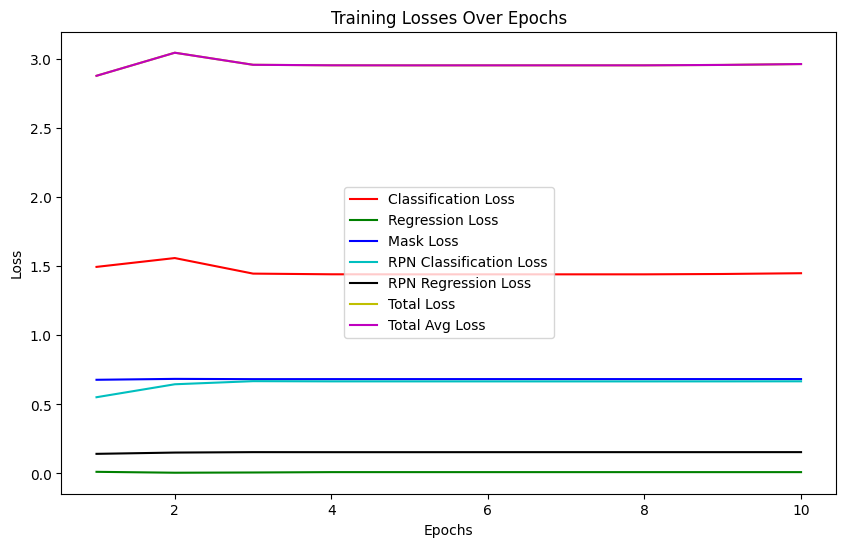

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis values (epochs)
epochs = range(1, len(train_losses['classification-loss']) + 1)

# Plot each loss type
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses['classification-loss'], 'r-', label='Classification Loss')
plt.plot(epochs, train_losses['regression-loss'], 'g-', label='Regression Loss')
plt.plot(epochs, train_losses['mask-loss'], 'b-', label='Mask Loss')
plt.plot(epochs, train_losses['rpn-classification-loss'], 'c-', label='RPN Classification Loss')
plt.plot(epochs, train_losses['rpn-regression-loss'], 'k-', label='RPN Regression Loss')
plt.plot(epochs, train_losses['total-avg'], 'y-', label='Total Loss')
plt.plot(epochs, train_losses['total-avg'], 'm-', label='Total Avg Loss')

# Adding labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()

# Show the plot
plt.show()